## Script to load in a processed seurat object and run pySCENIC

To get your processed Seurat object into adata format you can use conversion functions, such as:
```r
#load custom functions
source("/pl/active/CSUClinHeme/users/dylan/repos/scrna-seq/analysis-code/customFunctions_Seuratv5.R")

#load in processed R data and subset on cells of interest
seu.obj <- readRDS("../output/s3/240201_bm_cd34_removed_disconnected.rds")

cnts <- seu.obj@assays$RNA$counts
cnts <- orthogene::convert_orthologs(gene_df = cnts,
                                        gene_input = "rownames", 
                                        gene_output = "rownames", 
                                        input_species = "dog",
                                        output_species = "human",
                                        non121_strategy = "drop_both_species") 
rownames(cnts) <- unname(rownames(cnts))

seu.obj <- CreateSeuratObject(cnts, project = "humanConvert", assay = "RNA",
                                  min.cells = 0, min.features = 0, names.field = 1,
                                  names.delim = "_", meta.data = seu.obj@meta.data)

#covert back to an older Seurat object for compatiability with 
seu.obj[["RNA"]] <- as(object = seu.obj[["RNA"]], Class = "Assay")
seu.obj <- NormalizeData(seu.obj)

SaveH5Seurat(seu.obj, filename = "../output/s3/allcells_hu.h5Seurat", verbose = TRUE, overwrite = T)
Convert("../output/s3/allcells_hu.h5Seurat", dest = "h5ad", overwrite = T)

```

### Note: TF files were obtained from https://resources.aertslab.org/cistarget/

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from matplotlib.pyplot import rc_context
from MulticoreTSNE import MulticoreTSNE as TSNE
from pyscenic.export import export2loom, add_scenic_metadata

import seaborn as sns
import matplotlib.pyplot as plt
import scipy 

import glob

import json
import zlib
import base64

In [2]:
FIGURES_FOLDERNAME="../output/scenic/"
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [11]:
#load in the data
adata = sc.read_h5ad("../output/s3/allcells_hu.h5ad")
adata

AnnData object with n_obs × n_vars = 22988 × 11606
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.hbm', 'percent.ppbp', 'RNA_snn_res.0.1', 'seurat_clusters', 'int.clusID', 'pANN_0.25_0.01_274', 'DF.classifications_0.25_0.01_274', 'doublet', 'S.Score', 'G2M.Score', 'Phase', 'clusters', 'pANN_0.25_0.19_108', 'DF.classifications_0.25_0.19_108', 'pANN_0.25_0.02_98', 'DF.classifications_0.25_0.02_98', 'pANN_0.25_0.11_115', 'DF.classifications_0.25_0.11_115', 'pANN_0.25_0.005_95', 'DF.classifications_0.25_0.005_95', 'unintegrated_clusters', 'RNA_snn_res.0.6', 'clusterID_integrated.cca', 'clusterID_integrated.harmony', 'clusterID_integrated.joint', 'clusterID_integrated.rcpa', 'name', 'colz', 'cellSource', 'minorIdent'
    var: 'features'

In [12]:
#convert from numeric to string
anno = adata.obs
anno['clusterID_integrated.harmony'] = anno['clusterID_integrated.harmony'].astype(str)
adata.obs = anno

In [13]:
#convert index to gene symbol
tempAdata = adata.raw.to_adata()
tempAdata.var_names = adata.var['features']
adata.raw = tempAdata

In [6]:
#cant run b/c UMAP coords weren't brought over
# sc.pl.umap(adata, color=['IGHM','majorID_sub2','name'], use_raw = False)

In [7]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( "../output/s3/allcells_hu.loom", adata.X.transpose(), row_attrs, col_attrs)

The easiest way to run the code is to use a sbatch script, so generate a script with:

In [8]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_grn.sbatch
!echo "#SBATCH --job-name=pySCENIC_grn" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --ntasks=16" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --time=06:00:00" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --partition=amilan" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --output=pySCENIC_grn-%j.log" >> cute_pyScenic_grn.sbatch

!echo "" >> cute_pyScenic_grn.sbatch

!echo "module purge" >> cute_pyScenic_grn.sbatch

!echo "" >> cute_pyScenic_grn.sbatch

!echo "singularity exec -B $PWD/../ ../software/aertslab-pyscenic-scanpy-0.12.1-1.9.1.sif pyscenic grn \\" >> cute_pyScenic_grn.sbatch
!echo "--num_workers \$SLURM_NTASKS \\" >> cute_pyScenic_grn.sbatch
!echo "-o ../output/scenic/adj_allCells.csv \\" >> cute_pyScenic_grn.sbatch
!echo "../output/s3/allcells_hu.loom \\" >> cute_pyScenic_grn.sbatch
!echo "./metaData/allTFs_hg38.txt" >> cute_pyScenic_grn.sbatch

In [9]:
#submit the job
!sbatch cute_pyScenic_grn.sbatch

Submitted batch job 4706436


In [3]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_ctx.sbatch
!echo "#SBATCH --job-name=pySCENIC_ctx" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --ntasks=16" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --time=00:60:00" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --partition=atesting" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --output=pySCENIC_ctx-%j.log" >> cute_pyScenic_ctx.sbatch

!echo "" >> cute_pyScenic_ctx.sbatch

!echo "module purge" >> cute_pyScenic_ctx.sbatch

!echo "" >> cute_pyScenic_ctx.sbatch

!echo "singularity exec -B $PWD/../ ../software/aertslab-pyscenic-scanpy-0.12.1-1.9.1.sif pyscenic ctx \\" >> cute_pyScenic_ctx.sbatch
!echo "../output/scenic/adj_allCells.csv \\" >> cute_pyScenic_ctx.sbatch
!echo "./metaData/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather ./metaData/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \\" >> cute_pyScenic_ctx.sbatch
!echo "--annotations_fname ./metaData/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \\" >> cute_pyScenic_ctx.sbatch
!echo "--expression_mtx_fname ../output/s3/allcells_hu.loom \\" >> cute_pyScenic_ctx.sbatch
!echo "--output ../output/scenic/reg_allCells.csv \\" >> cute_pyScenic_ctx.sbatch
!echo "--mask_dropouts \\" >> cute_pyScenic_ctx.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_ctx.sbatch


In [4]:
#submit the job; took 8 min....
!sbatch cute_pyScenic_ctx.sbatch

Submitted batch job 4994510


In [5]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_aucell.sbatch
!echo "#SBATCH --job-name=pySCENIC_auc" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --ntasks=8" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --time=0:20:00" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --partition=atesting" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --output=pySCENIC_auc-%j.log" >> cute_pyScenic_aucell.sbatch

!echo "" >> cute_pyScenic_aucell.sbatch
!echo "module purge" >> cute_pyScenic_aucell.sbatch

!echo "" >> cute_pyScenic_aucell.sbatch

!echo "singularity exec -B $PWD/../ ../software/aertslab-pyscenic-scanpy-0.12.1-1.9.1.sif pyscenic aucell \\" >> cute_pyScenic_aucell.sbatch
!echo "../output/s3/allcells_hu.loom \\" >> cute_pyScenic_aucell.sbatch
!echo "../output/scenic/reg_allCells.csv \\" >> cute_pyScenic_aucell.sbatch
!echo "--output ../output/scenic/allcells_hu_output.loom \\" >> cute_pyScenic_aucell.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_aucell.sbatch


In [6]:
#took 2 min....
!sbatch cute_pyScenic_aucell.sbatch

Submitted batch job 4994690


In [9]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
# from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [77]:
# collect SCENIC AUCell output
# lf = lp.connect("./output/scenic/dc_scenic_output_231023.loom", mode='r+', validate=False )
lf = lp.connect("../output/scenic/allcells_hu_output.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

#write to .csv to load in Seurat object
pd.DataFrame.to_csv(auc_mtx, "../output/scenic/auc_mtx_allcells_hu.csv")

### Calculate RSS and save as .csv for further plotting

In [ ]:
rss = regulon_specificity_scores(auc_mtx, adata.obs['clusterID_integrated.harmony'])
pd.DataFrame.to_csv(rss, "../output/scenic/allcells_hu_rss.csv")

R code to plot the RSS results
```r
library(tidyverse)
library(ggrepel)
library(patchwork)

df <- read.csv("../output/scenic/allcells_hu_rss.csv", row.names = 1)
colnames(df) <- gsub('\\.\\.\\.',"",colnames(df))
df.all <- t(df) %>% as.data.frame() %>% rownames_to_column() %>% na.omit()

labCut = 10
pi <- lapply(2:ncol(df.all), function(x){
    #prep data
    celltype <- colnames(df.all)[x]
    df <- df.all[ ,c("rowname",celltype)] 
    colnames(df) <- c("gene", "clus")
    df <- df %>% arrange(desc(clus))
    df[ ,"gene"] <- factor(df[ ,"gene"], levels = df[ ,"gene"])
    df <- df %>% mutate(colz = ifelse(row_number() < labCut+1, "#FF6961", "lightblue"),
                        labz = ifelse(row_number() < labCut+1, as.character(gene), NA))
    
    #plot the data
    p <- ggplot(df, aes(x = gene, y = clus, label = labz)) +
    geom_point(colour = df$colz, size = 2) + 
    geom_text_repel(
        force = 0.01,
        nudge_x = nrow(df)*0.5,
        direction = "y",
        seed = 42, 
        box.padding = 0.25,
        #hjust = 0,
        #segment.size = 0.2, 
        size = 4, 
        color = df$colz,
        max.iter = 100000000,
        max.overlaps = 10
    ) + 
    labs(
        title = celltype,
        x = "Regulon",
        y = "rss"
    ) + 
    theme_classic() + 
    theme(
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        panel.border = element_blank(),
        plot.margin = unit(c(10, 10, 10, 10), "pt"),
        panel.background = element_rect(fill = "transparent",colour = NA),
        plot.background = element_rect(fill = "transparent",colour = NA),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()
    ) + 
    scale_y_continuous(
        breaks = function(y) {
            seq(floor(min(y, digits = 1)), 
            ceiling(max(y, digits = 1)), 
            by = 0.1)
        }
    ) + coord_cartesian(expand = TRUE, clip = "off")

    #return/save plot
    ggsave(paste0("../output/scenic/", gsub(" ", "_", celltype), "_rss.png"), height = 5, width = 3)
    return(p)
})


p <- Reduce( `+`, pi) + plot_layout(ncol = 6)
ggsave(plot = p, "../output/scenic/main_branches_rss.png", height = 4, width = 10)

```

### Extract data for further plotting

In [53]:
#clean the matrix to join
auc_mtx.index.name = 'barcode'
auc_mtx.reset_index(inplace=True)

#clean the cell barcode info
dicT = {'barcode' : adata.obs.index.tolist(), 
        'clusterID_integrated.harmony' : adata.obs['clusterID_integrated.harmony'].tolist()}
cellAnn = pd.DataFrame(dicT)

#join the data
auc_mtx = auc_mtx.merge(cellAnn, on = 'barcode', how = 'left')

In [73]:
#calc Z score for each regulon by cluster ID
regColNames = list(auc_mtx.columns[1:len(auc_mtx.columns)-1])
df_res = ((auc_mtx.groupby(by='clusterID_integrated.harmony').mean() - auc_mtx[regColNames].mean())/ auc_mtx[regColNames].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_res['regulon'] = list(map(lambda s: s[0:-3], df_res.regulon))
df_res[(df_res.Z >= 3.0)].sort_values('Z', ascending=False).head()

,clusterID_integrated.harmony,regulon,Z
2376,15,GFI1B,5.369871
2487,15,RB1,5.000990
2448,15,NFIA,4.942622
2518,15,SOX6,4.929132
2328,15,E2F4,4.910385


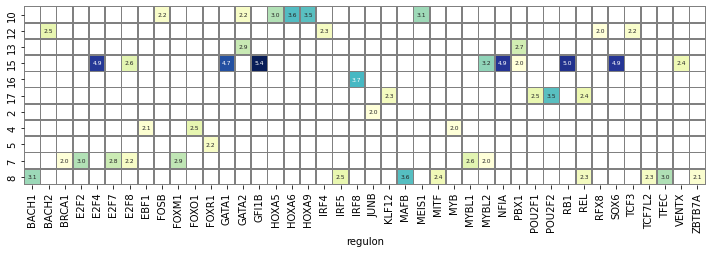

In [76]:
df_heatmap = pd.pivot_table(data = df_res[df_res.Z >= 2.0].sort_values('Z', ascending = False),
                           index = 'clusterID_integrated.harmony', columns = 'regulon', values = 'Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')
savesvg('heatmap.svg', fig)

### Load in the auc_mtx data to plot TF activity and reduce data based in the results

In [ ]:
#load in the data
outName <- "scenic"
seu.obj <- readRDS("../output/s3/240201_bm_cd34_removed_disconnected.rds")
df <- read.csv("../output/scenic/auc_mtx_allcells_hu.csv", row.names = 1)
colnames(df) <- gsub('\\.\\.\\.',"-tf",colnames(df))

tf_assay <- CreateAssay5Object(counts = t(df))
seu.obj[["TF"]] <- tf_assay

DefaultAssay(seu.obj) <- "TF"
seu.obj <- ScaleData(seu.obj)
seu.obj@reductions$tf <- seu.obj@assays$TF$scale.data

seu.obj <- IntegrateLayers(object = seu.obj, 
                           assay = "TF",
                                   method = HarmonyIntegration, 
                                   orig.reduction = "tf", 
                                   new.reduction = "integrated.harmony",
                                   normalization.method = "LogNormalize",
                                   verbose = FALSE)


DefaultAssay(seu.obj) <- "TF"
seu.obj@assays$TF$data <- seu.obj@assays$TF$counts
features <- c("HOXA9-tf", "GATA1-tf", "MAFB-tf",
              "JUNB-tf","IRF8-tf")
p1 <- FeaturePlot(seu.obj, features, cols = c("lightgrey", "darkgreen"), reduction = "umap.integrated.harmony")
p <- prettyFeats(seu.obj = seu.obj, nrow = 2, ncol = 3, title.size = 14, features = features, order = F, legJust = "top", reduction = "umap.integrated.harmony") 
ggsave(paste0("../output/", outName, "/", outName, "_tfPlots.png"), width = 9, height = 6)

DefaultAssay(seu.obj) <- "RNA"
features <- c("HOXA9", "GATA1", "MAFB",
              "JUNB","IRF8")
p2 <- FeaturePlot(seu.obj, features, reduction = "umap.integrated.harmony")
ggsave(paste0("../output/", outName, "/", outName, "_featPlots.png"), width = 9, height = 6)